In [124]:
import numpy as np
import matplotlib.pyplot as plt
import jieba
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.layers import Embedding

In [139]:
class Param():
    batch_size = 32
    n_epoch = 50
    seq_length = 20
    metadata = 'metadata.tsv'
    n_step = 3
    n_batches_per_epoch = 50
    lyrics_long = 360

    
    remove_word = ['!', '(', ')', '*', '+', ',', '-', '.',
                   '...', '......', '............', '/','<',
                   '>', '?','[', '\\', ']', '`','~', '·',
                   '…', '☆', '\u3000', '。', '〇', '《', '》',
                   '〖', '〗', 'ー', 'ㄇ', 'ㄈ', 'ㄌ', 'ㄒ', 'ㄙ','！',
                   'ㄚ', 'ㄟ', 'ㄡ','（','）','，','＜','＞','？','～']   

In [130]:
class DataGenerator():
    def __init__(self, datafiles, args):
        self.seq_length = args.seq_length
        self.batch_size = args.batch_size
        self.n_step = args.n_step
        
        self.remove_word = args.remove_word
        self.remove_word = ''.join(self.remove_word)        
        
        with open(datafiles, encoding='utf-8') as f:
            self.data = f.read()
        
        self.seg_list = list(jieba.cut(self.data, cut_all=False))
        
        table = str.maketrans('','',self.remove_word)
        self.seg_list = [w.translate(table) for w in self.seg_list]
                
        # total data length
        self.total_len = len(self.seg_list)  
        self.words = list(set(self.seg_list))
        self.words.sort()
        print('Total length: {}'.format(self.total_len))
        
        # vocabulary
        self.vocab_size = len(self.words)  # vocabulary size
        print('Vocabulary Size:', self.vocab_size)
        
        # dictionary
        self.char2id_dict = {w: i for i, w in enumerate(self.words)}
        self.id2char_dict = {i: w for i, w in enumerate(self.words)}
        
        # pointer position to generate current batch
        self._pointer = 0
        # save metadata file
        self.save_metadata(args.metadata)
        
        self.max_iter = args.n_epoch * \
            (self.total_len // args.seq_length) // args.batch_size
        
    def char2id(self, c):
        return self.char2id_dict[c]
    
    def id2char(self, id):
        return self.id2char_dict[id]
    
    def save_metadata(self, file):
        with open(file, 'w', encoding="utf-8") as f:
            f.write('id\tchar\n')
            for i in range(self.vocab_size):
                c = self.id2char(i)
                f.write('{}\t{}\n'.format(i, c))
                
#     def create_tokenizer(self):
#         tokenizer = Tokenizer()
#         tokenizer.fit_on_texts(self.seg_list)
#         return tokenizer
    
    def next_batch(self):
        x_batches = []
        y_batches = []
        for i in range(self.batch_size):
            if self._pointer + self.seq_length + 1 >= self.total_len:
                self._pointer = 0

            bx = self.seg_list[self._pointer: self._pointer + self.seq_length]
#             by = self.seg_list[self._pointer +
#                            1: self._pointer + self.seq_length + 1]
            by = self.seg_list[self._pointer + self.seq_length]

            # update pointer position
            self._pointer += 1

            # convert to ids
            bx = [self.char2id(c) for c in bx]
            by = [self.char2id(by)]

            by = to_categorical(by, num_classes=self.vocab_size)[0]

            x_batches.append(bx)
            y_batches.append(by)
        
        return x_batches, y_batches
    
    
    def data_generator(self):
        while 1:
        # loop over photo identifiers in the dataset

            for i in range(0, self.max_iter, self.n_step):
                XSeq, y = list(), list()
                for j in range(i, min(self.max_iter, i+self.n_step)):

                    # generate input-output pairs
                    in_seq, out_word = self.next_batch()

                    for k in range(len(in_seq)):
                        XSeq.append(in_seq[k])
                        y.append(out_word[k])
                # yield this batch of samples to the model
                yield [np.array(XSeq), np.array(y)]

In [131]:
def define_model(args, data):

    # embedding
    inputs = Input(shape=(args.seq_length,))
    emb2 = Embedding(data.vocab_size, 50, mask_zero=True)(inputs)
    emb3 = LSTM(256)(emb2)

    # language model (decoder)
#     lm2 = LSTM(256)(emb3)
    lm3 = Dense(500, activation='relu')(emb3)
    outputs = Dense(data.vocab_size, activation='softmax')(lm3)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='plot.png')

    return model

In [142]:
lyrics = "jaychou_lyrics_traditional.txt"
JIEBA_DICTFILE_PATH = "D:/Program/model/jieba/dict.txt.big.txt"
jieba.set_dictionary(JIEBA_DICTFILE_PATH) 

args = Param()
data = DataGenerator(lyrics, args)

Building prefix dict from D:\Program\model\jieba\dict.txt.big.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u5f50f2b7ab381204f5f6032f217b280e.cache
Loading model cost 1.465 seconds.
Prefix dict has been built succesfully.


Total length: 43933
Vocabulary Size: 5801


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 50)            290050    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               128500    
_________________________________________________________________
dense_6 (Dense)              (None, 5801)              2906301   
Total params: 3,639,219
Trainable params: 3,639,219
Non-trainable params: 0
_________________________________________________________________
None


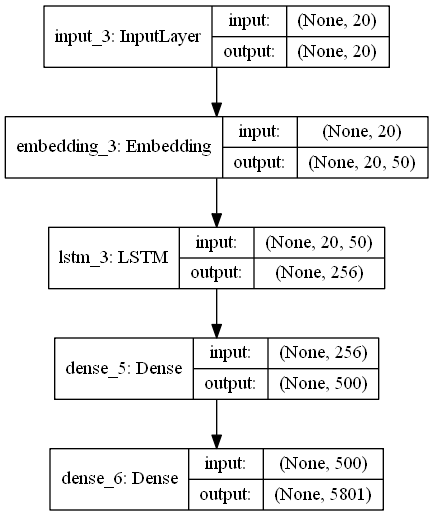

In [133]:
from IPython.display import Image

model = define_model(args, data)
Image('plot.png')

In [135]:
model.fit_generator(data.data_generator(), steps_per_epoch=args.n_batches_per_epoch, 
                    epochs=args.n_epoch, verbose=2)


Epoch 1/50
 - 13s - loss: 6.9993 - acc: 0.1977
Epoch 2/50
 - 6s - loss: 6.7434 - acc: 0.1965
Epoch 3/50
 - 6s - loss: 6.8880 - acc: 0.1787
Epoch 4/50
 - 6s - loss: 6.3748 - acc: 0.2006
Epoch 5/50
 - 6s - loss: 6.5553 - acc: 0.2042
Epoch 6/50
 - 6s - loss: 6.3172 - acc: 0.2048
Epoch 7/50
 - 6s - loss: 6.4244 - acc: 0.1881
Epoch 8/50
 - 6s - loss: 6.2777 - acc: 0.1946
Epoch 9/50
 - 6s - loss: 6.4004 - acc: 0.2048
Epoch 10/50
 - 6s - loss: 5.7263 - acc: 0.1963
Epoch 11/50
 - 6s - loss: 5.8002 - acc: 0.1933
Epoch 12/50
 - 6s - loss: 5.9356 - acc: 0.1869
Epoch 13/50
 - 6s - loss: 5.6851 - acc: 0.1975
Epoch 14/50
 - 6s - loss: 5.6515 - acc: 0.1998
Epoch 15/50
 - 7s - loss: 5.6520 - acc: 0.2033
Epoch 16/50
 - 7s - loss: 5.9505 - acc: 0.1917
Epoch 17/50
 - 7s - loss: 5.5138 - acc: 0.2031
Epoch 18/50
 - 6s - loss: 5.4905 - acc: 0.2075
Epoch 19/50
 - 6s - loss: 5.0311 - acc: 0.2129
Epoch 20/50
 - 6s - loss: 5.4283 - acc: 0.2010
Epoch 21/50
 - 6s - loss: 5.4175 - acc: 0.1894
Epoch 22/50
 - 7s - l

In [152]:
# generate a description for an image
def generate_desc(model, args, data, in_text):
    # seed the generation process

    # iterate over the whole length of the sequence
    for i in range(args.lyrics_long):
        # integer encode input sequence

        in_text_list = list(jieba.cut(in_text, cut_all=False))
        in_seq = [data.char2id(c) for c in in_text_list]

        # pad input
        sequence = pad_sequences([in_seq], maxlen=data.seq_length)
        # predict next word
        yhat = model.predict(sequence, verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = data.id2char(yhat)
        # stop if we cannot map the word
#         if word is None:
#             break
        # append as input for generating the next word
        in_text += word
        # stop if we predict the end of the sequence
        # if word == 'endseq':
        #     break
    return in_text

In [154]:
in_text = '1983'

generate_desc(model, args, data,in_text)

'1983我的我 我 我'

['',
 ' ',
 '12',
 '1983',
 'AB',
 'ABC',
 'Baby',
 'Blues',
 'CNN',
 'Chou',
 'Coffee',
 'E',
 'END',
 'FJR',
 'Fantasy',
 'GO',
 'Gray',
 'Guitar',
 'Ha',
 'HandsomeCK',
 'Hei',
 'Hi',
 'Hoi',
 'Ice',
 'J',
 'Jay',
 'MUSIC',
 'Mr',
 'Music',
 'MusicMusic',
 'Na',
 'OH',
 'OVERTURE',
 'Oh',
 'OhOh',
 'Peace',
 'Pick',
 'Plus',
 'Rap',
 'Rocker',
 'V',
 'Wu',
 'Ya',
 'dedefa',
 'dou',
 'fade',
 'fafa',
 'fafade',
 'gi',
 'gia',
 'hey',
 'ki',
 'la',
 'me',
 'mia',
 'music',
 'oh',
 'or',
 'rap',
 'rui',
 'sou',
 'tea',
 'tia',
 'wo',
 'xi',
 'yeah',
 '一',
 '一一',
 '一下',
 '一不注意',
 '一九四三',
 '一些',
 '一代',
 '一件',
 '一位',
 '一個',
 '一兩張',
 '一再',
 '一出',
 '一分一秒',
 '一切',
 '一列',
 '一匹',
 '一半',
 '一口',
 '一口氣',
 '一句',
 '一名',
 '一回',
 '一圈',
 '一團',
 '一地',
 '一堆',
 '一場',
 '一塊',
 '一壺',
 '一夕之間',
 '一夜',
 '一天',
 '一天到晚',
 '一如',
 '一季',
 '一定',
 '一家',
 '一巴掌',
 '一帖',
 '一幅',
 '一幕',
 '一幕幕',
 '一張',
 '一想',
 '一截',
 '一把',
 '一抹',
 '一拳',
 '一擊',
 '一支',
 '一放',
 '一整夜',
 '一旁',
 '一時',
 '一曲',
 '一本',
 '一朵',
 '一束',
 '一枚',
 '一枝',
 '一